In [6]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import os
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [7]:
#Importing the raw image data using a utility present in Keras.
data_dir= 'train'
img_height = 200
img_width = 200 #Converting all the images into 200*200 size.
batch_size=32

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
#We can see that there are total 4767 images present in the dataset.

Found 4767 files belonging to 12 classes.
Using 3814 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4767 files belonging to 12 classes.
Using 953 files for validation.


In [9]:
class_names = train_ds.class_names
class_names #Names of different classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

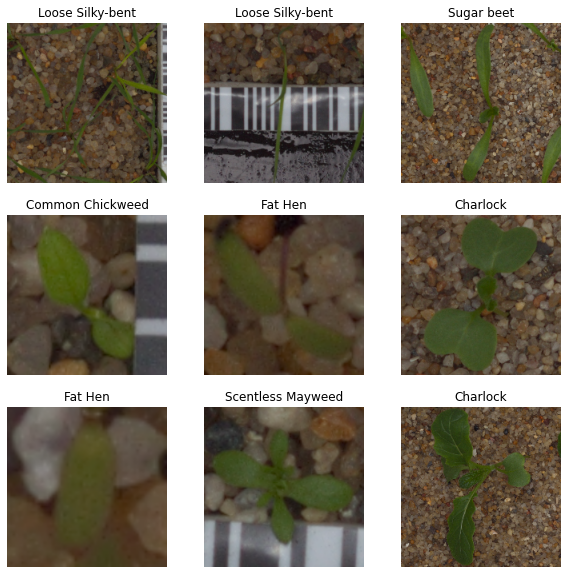

In [10]:
#Let's visualize first 9 images from the dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [34]:
#Let's prepare suitable datasets for supervised and neural network algorithms.
def dataset_converter(data):
    class_names = list(data.class_names)
    class_dict = {}
    train_labels=[]
    img_ds = np.array([])
    for image_batch, labels_batch in data: #Batchwise conversion of data
        img_array = image_batch.numpy() #Converting the data into ndarray
        for i in list(labels_batch.numpy()):
            train_labels.append(i)#Appending the labels to the master labels' list
        for j in img_array:
            j1 = np.mean(j,axis=2) #Converting the image data into greyscale
            j1=j1/255
            j1 = j1.reshape(1,400) #Vectorizing the data instance
            if img_ds.shape[0]==0:
                img_ds = np.copy(j1)
            else:
                img_ds = np.append(img_ds,j1,axis=0)
    return img_ds, pd.Series(train_labels)

In [32]:
#Let's import the images once again, this time in form of 15*15 images, instead of the previous 100*100 images, for having lower dimensionality.
train_ds1 = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(20, 20),
  batch_size=batch_size)

val_ds1 = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(20, 20),
  batch_size=batch_size)

Found 4767 files belonging to 12 classes.
Using 3814 files for training.
Found 4767 files belonging to 12 classes.
Using 953 files for validation.


In [35]:
X_train, y_train = dataset_converter(train_ds1)

In [36]:
X_val, y_val = dataset_converter(val_ds1)

In [68]:
X_train.shape

(3814, 400)

In [38]:
#One hot encoding the labels now.
y_train1 = tf.keras.utils.to_categorical(y_train, num_classes=12)
y_val1 = tf.keras.utils.to_categorical(y_val, num_classes=12)

In [39]:
#Let's start with supervised learning now.
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

svc = svm.SVC()
rfc=RandomForestClassifier(n_estimators = 50, random_state=1)

In [40]:
svc.fit(X_train,y_train)
rfc.fit(X_train,y_train)

RandomForestClassifier(n_estimators=50, random_state=1)

In [46]:
print("Support vector machine scores:-")
print("Training accuracy:",svc.score(X_train,y_train))
print("Validation accuracy:",svc.score(X_val,y_val))
print("Random forest scores:-")
print("Training accuracy:",rfc.score(X_train,y_train))
print("Validation accuracy:",rfc.score(X_val,y_val))

Support vector machine scores:-
Training accuracy: 0.6342422653382276
Validation accuracy: 0.25603357817418676
Random forest scores:-
Training accuracy: 1.0
Validation accuracy: 0.24344176285414482


In [ ]:
#There is a very high amount of bias and variance present in the support vector machine classifier.
#Extreme overfitting can be seen in case of random forest classifier.
'''For such a relatively small dataset like this, with these many number of features for highly
   pixeleted images of 20*20 dimensions, there's not much of a point of performing hyperparameter tuning here.'''

In [50]:
#For dimensionality reduction, let's try PCA.
from sklearn.decomposition import PCA
pca = PCA(n_components=200)

In [53]:
pca.fit(X_train)

PCA(n_components=200)

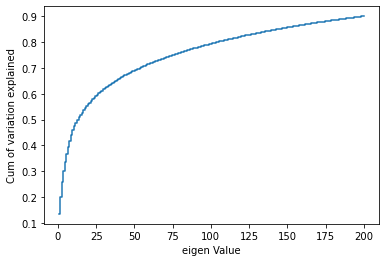

In [55]:
plt.step(list(range(1,201)),np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Cum of variation explained')
plt.xlabel('eigen Value')

plt.show()

In [61]:
#As we can see that only 100 components out of total 400 components can explain more than 80% of the variance of the training data.
pca1 = PCA(n_components=200)
pca1.fit(X_train)
X_train_pca = pca1.transform(X_train)
X_val_pca = pca1.transform(X_val)

In [62]:
#Let's try the supervised algorithms on the data with reduced dimensionality.
svc_pca = svm.SVC()
rfc_pca=RandomForestClassifier(n_estimators = 50, random_state=1)
svc_pca.fit(X_train_pca,y_train)
rfc_pca.fit(X_train_pca,y_train)
print("Support vector machine with PCA scores:-")
print("Training accuracy:",svc_pca.score(X_train_pca,y_train))
print("Validation accuracy:",svc_pca.score(X_val_pca,y_val))
print("Random forest with PCA scores:-")
print("Training accuracy:",rfc_pca.score(X_train_pca,y_train))
print("Validation accuracy:",rfc_pca.score(X_val_pca,y_val))
#There's not much of a difference in the performance of the algorithms, even after dimensionality reduction.

Support vector machine with PCA scores:-
Training accuracy: 0.5957000524383849
Validation accuracy: 0.2539349422875131
Random forest with PCA scores:-
Training accuracy: 1.0
Validation accuracy: 0.20566631689401887


In [71]:
#Let's try neural networks now.
#Creating a function to train the neural networks, in order to avoid repetition of code.
from tensorflow.keras import optimizers
def train_model(activation_fn,reg_lambda,ep,optimizer,lr):
    model = Sequential()
    #Let's consider 2 hidden layers with 100 units in each one.
    model.add(layers.Dense(100, input_shape=(400,), activation=activation_fn))
    model.add(layers.Dense(100, activation=activation_fn))
    model.add(layers.Dense(12, activation='softmax', kernel_regularizer=regularizers.l2(reg_lambda)))
    #Considering 2 optimizers, gradient decent and relu, with default hyperparameters.
    sgd = optimizers.SGD(learning_rate=lr)
    adam = optimizers.Adam(learning_rate=lr)
    if optimizer == 'sgd':
        model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    else:
        model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    model.fit(X_train, y_train1, epochs=ep, batch_size=32, verbose= 1)
    score = model.evaluate(X_val, y_val1, verbose=0)
    
    return score

In [73]:
#Let's train a neural network without any regularization and with defaut learning rate
train_model(activation_fn='relu',
            reg_lambda=0,
            ep=100,
            optimizer='sgd',
            lr=0.001)
#Very fast training, but poor accuracy .

Epoch 1/100
120/120 [==============================] - 1s 2ms/step - loss: 2.5155 - accuracy: 0.0517
Epoch 2/100
120/120 [==============================] - 0s 2ms/step - loss: 2.4906 - accuracy: 0.0734
Epoch 3/100
120/120 [==============================] - 0s 2ms/step - loss: 2.4743 - accuracy: 0.1127
Epoch 4/100
120/120 [==============================] - 0s 3ms/step - loss: 2.4633 - accuracy: 0.1285
Epoch 5/100
120/120 [==============================] - 0s 3ms/step - loss: 2.4545 - accuracy: 0.1319
Epoch 6/100
120/120 [==============================] - 0s 3ms/step - loss: 2.4473 - accuracy: 0.1356
Epoch 7/100
120/120 [==============================] - 0s 2ms/step - loss: 2.4415 - accuracy: 0.1358
Epoch 8/100
120/120 [==============================] - 0s 2ms/step - loss: 2.4364 - accuracy: 0.1377
Epoch 9/100
120/120 [==============================] - 0s 2ms/step - loss: 2.4322 - accuracy: 0.1403
Epoch 10/100
120/120 [==============================] - 0s 2ms/step - loss: 2.4288 - accura

[2.3964922428131104, 0.1668415516614914]

In [74]:
#Let's try adam optimizer.
train_model(activation_fn='relu',
            reg_lambda=0,
            ep=100,
            optimizer='adam',
            lr=0.001)
#Training accuracy has increased, but poor validation accuracy. Overfitting has occured.

Epoch 1/100
120/120 [==============================] - 1s 2ms/step - loss: 2.4252 - accuracy: 0.1476
Epoch 2/100
120/120 [==============================] - 0s 2ms/step - loss: 2.3989 - accuracy: 0.1445
Epoch 3/100
120/120 [==============================] - 0s 2ms/step - loss: 2.3739 - accuracy: 0.1639
Epoch 4/100
120/120 [==============================] - 0s 2ms/step - loss: 2.3477 - accuracy: 0.1770
Epoch 5/100
120/120 [==============================] - 0s 2ms/step - loss: 2.3249 - accuracy: 0.1820
Epoch 6/100
120/120 [==============================] - 0s 2ms/step - loss: 2.3039 - accuracy: 0.1969
Epoch 7/100
120/120 [==============================] - 0s 2ms/step - loss: 2.2803 - accuracy: 0.1987
Epoch 8/100
120/120 [==============================] - 0s 2ms/step - loss: 2.2579 - accuracy: 0.2048
Epoch 9/100
120/120 [==============================] - 0s 2ms/step - loss: 2.2462 - accuracy: 0.2095
Epoch 10/100
120/120 [==============================] - 0s 2ms/step - loss: 2.2263 - accura

[2.9688680171966553, 0.21720881760120392]

In [77]:
#Let's introduce regularization and let's tweak the learning rate
train_model(activation_fn='relu',
            reg_lambda=0.01,
            ep=100,
            optimizer='adam',
            lr=0.001)
#Still overfitting can be seen, along with poor training accuracy.

Epoch 1/100
120/120 [==============================] - 1s 2ms/step - loss: 2.5662 - accuracy: 0.1387
Epoch 2/100
120/120 [==============================] - 0s 2ms/step - loss: 2.4586 - accuracy: 0.1547
Epoch 3/100
120/120 [==============================] - 0s 2ms/step - loss: 2.4085 - accuracy: 0.1626
Epoch 4/100
120/120 [==============================] - 0s 2ms/step - loss: 2.3835 - accuracy: 0.1712
Epoch 5/100
120/120 [==============================] - 0s 2ms/step - loss: 2.3544 - accuracy: 0.1822
Epoch 6/100
120/120 [==============================] - 0s 2ms/step - loss: 2.3378 - accuracy: 0.1814
Epoch 7/100
120/120 [==============================] - 0s 2ms/step - loss: 2.3224 - accuracy: 0.1854
Epoch 8/100
120/120 [==============================] - 0s 2ms/step - loss: 2.3073 - accuracy: 0.2011
Epoch 9/100
120/120 [==============================] - 0s 2ms/step - loss: 2.2869 - accuracy: 0.2074
Epoch 10/100
120/120 [==============================] - 0s 2ms/step - loss: 2.2745 - accura

[2.613419532775879, 0.2098635882139206]

In [81]:
#Let's add dropout and batch norm layers in the neural network.
from tensorflow.keras.layers import BatchNormalization, Dropout
def train_model2(activation_fn,reg_lambda,ep,optimizer,lr):
    model = Sequential()
    #Let's consider 2 hidden layers with 100 units in each one.
    model.add(layers.Dense(100, input_shape=(400,), activation=activation_fn))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(layers.Dense(100, activation=activation_fn))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(layers.Dense(12, activation='softmax', kernel_regularizer=regularizers.l2(reg_lambda)))
    #Considering 2 optimizers, gradient decent and relu, with default hyperparameters.
    sgd = optimizers.SGD(learning_rate=lr)
    adam = optimizers.Adam(learning_rate=lr)
    if optimizer == 'sgd':
        model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    else:
        model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    mod1 = model.fit(X_train, y_train1, epochs=ep, batch_size=32, verbose= 1)
    score = model.evaluate(X_val, y_val1, verbose=0)
    
    return score, mod1

In [85]:
#Let's try randomized search strategy for hyperparameter tuning of learning rate and regularization factor.
import math
for k in range(1,10):
    lr1 = math.pow(10, np.random.uniform(-6, -4))
    Lambda = math.pow(10, np.random.uniform(-5,-3))
    best_acc = train_model2(activation_fn='relu',
                reg_lambda=Lambda,
                ep=60,
                optimizer='adam',
                lr=lr1)
    print("Try {0}/{1}: Best_val_acc: {2}, lr: {3}, Lambda: {4}\n".format(k, 10, best_acc, lr1, Lambda))

Epoch 1/60
120/120 [==============================] - 1s 3ms/step - loss: 3.4200 - accuracy: 0.0763
Epoch 2/60
120/120 [==============================] - 0s 3ms/step - loss: 3.3986 - accuracy: 0.0863
Epoch 3/60
120/120 [==============================] - 0s 3ms/step - loss: 3.3797 - accuracy: 0.0792
Epoch 4/60
120/120 [==============================] - 0s 3ms/step - loss: 3.3546 - accuracy: 0.0773
Epoch 5/60
120/120 [==============================] - 0s 2ms/step - loss: 3.3603 - accuracy: 0.0836
Epoch 6/60
120/120 [==============================] - 0s 2ms/step - loss: 3.3546 - accuracy: 0.0884
Epoch 7/60
120/120 [==============================] - 0s 2ms/step - loss: 3.3377 - accuracy: 0.0826
Epoch 8/60
120/120 [==============================] - 0s 2ms/step - loss: 3.3248 - accuracy: 0.0870
Epoch 9/60
120/120 [==============================] - 0s 2ms/step - loss: 3.3645 - accuracy: 0.0818
Epoch 10/60
120/120 [==============================] - 0s 2ms/step - loss: 3.3117 - accuracy: 0.0810

120/120 [==============================] - 0s 3ms/step - loss: 2.8174 - accuracy: 0.1264
Epoch 40/60
120/120 [==============================] - 0s 3ms/step - loss: 2.8095 - accuracy: 0.1356
Epoch 41/60
120/120 [==============================] - 0s 3ms/step - loss: 2.8349 - accuracy: 0.1259
Epoch 42/60
120/120 [==============================] - 0s 3ms/step - loss: 2.8029 - accuracy: 0.1353
Epoch 43/60
120/120 [==============================] - 0s 3ms/step - loss: 2.7946 - accuracy: 0.1379
Epoch 44/60
120/120 [==============================] - 0s 3ms/step - loss: 2.7665 - accuracy: 0.1358
Epoch 45/60
120/120 [==============================] - 0s 3ms/step - loss: 2.7573 - accuracy: 0.1321
Epoch 46/60
120/120 [==============================] - 0s 3ms/step - loss: 2.7899 - accuracy: 0.1324
Epoch 47/60
120/120 [==============================] - 0s 3ms/step - loss: 2.7719 - accuracy: 0.1350
Epoch 48/60
120/120 [==============================] - 0s 2ms/step - loss: 2.7576 - accuracy: 0.1408
Ep

120/120 [==============================] - 0s 2ms/step - loss: 3.3223 - accuracy: 0.0823
Epoch 16/60
120/120 [==============================] - 0s 2ms/step - loss: 3.3422 - accuracy: 0.0792
Epoch 17/60
120/120 [==============================] - 0s 2ms/step - loss: 3.3285 - accuracy: 0.0836
Epoch 18/60
120/120 [==============================] - 0s 3ms/step - loss: 3.3379 - accuracy: 0.0836
Epoch 19/60
120/120 [==============================] - 0s 3ms/step - loss: 3.3389 - accuracy: 0.0763
Epoch 20/60
120/120 [==============================] - 0s 2ms/step - loss: 3.3091 - accuracy: 0.0789
Epoch 21/60
120/120 [==============================] - 0s 2ms/step - loss: 3.3032 - accuracy: 0.0897
Epoch 22/60
120/120 [==============================] - 0s 2ms/step - loss: 3.3123 - accuracy: 0.0805
Epoch 23/60
120/120 [==============================] - 0s 2ms/step - loss: 3.3032 - accuracy: 0.0813
Epoch 24/60
120/120 [==============================] - 0s 2ms/step - loss: 3.3363 - accuracy: 0.0852
Ep

120/120 [==============================] - 0s 3ms/step - loss: 1.9785 - accuracy: 0.3207
Epoch 54/60
120/120 [==============================] - 0s 3ms/step - loss: 1.9694 - accuracy: 0.3309
Epoch 55/60
120/120 [==============================] - 0s 3ms/step - loss: 1.9539 - accuracy: 0.3319
Epoch 56/60
120/120 [==============================] - 0s 3ms/step - loss: 1.9656 - accuracy: 0.3332
Epoch 57/60
120/120 [==============================] - 0s 3ms/step - loss: 1.9440 - accuracy: 0.3427
Epoch 58/60
120/120 [==============================] - 0s 3ms/step - loss: 1.9232 - accuracy: 0.3406
Epoch 59/60
120/120 [==============================] - 0s 3ms/step - loss: 1.9310 - accuracy: 0.3458
Epoch 60/60
120/120 [==============================] - 0s 3ms/step - loss: 1.9031 - accuracy: 0.3466
Try 8/10: Best_val_acc: ([2.3080897331237793, 0.2098635882139206], <keras.callbacks.History object at 0x000001EA06A89E50>), lr: 9.348960935981421e-05, Lambda: 0.0002638881164030507

Epoch 1/60
120/120 [==

In [87]:
#Let's increase the number of epochs for the best possible hyperparameter combination, lr = 9e5 and lambda = 0.000264
best_acc,mod1 = train_model2(activation_fn='relu',
                reg_lambda=0.000264,
                ep=200,
                optimizer='adam',
                lr=0.00009)

Epoch 1/200
120/120 [==============================] - 2s 3ms/step - loss: 3.2391 - accuracy: 0.0878
Epoch 2/200
120/120 [==============================] - 0s 3ms/step - loss: 3.0452 - accuracy: 0.1093
Epoch 3/200
120/120 [==============================] - 0s 3ms/step - loss: 2.9324 - accuracy: 0.1177
Epoch 4/200
120/120 [==============================] - 0s 3ms/step - loss: 2.8282 - accuracy: 0.1306
Epoch 5/200
120/120 [==============================] - 0s 3ms/step - loss: 2.7516 - accuracy: 0.1400
Epoch 6/200
120/120 [==============================] - 0s 2ms/step - loss: 2.6902 - accuracy: 0.1439
Epoch 7/200
120/120 [==============================] - 0s 3ms/step - loss: 2.6308 - accuracy: 0.1521
Epoch 8/200
120/120 [==============================] - 0s 3ms/step - loss: 2.5942 - accuracy: 0.1636
Epoch 9/200
120/120 [==============================] - 0s 3ms/step - loss: 2.5643 - accuracy: 0.1754
Epoch 10/200
120/120 [==============================] - 0s 3ms/step - loss: 2.5228 - accura

120/120 [==============================] - 0s 2ms/step - loss: 1.4040 - accuracy: 0.5312
Epoch 161/200
120/120 [==============================] - 0s 2ms/step - loss: 1.4138 - accuracy: 0.5155
Epoch 162/200
120/120 [==============================] - 0s 2ms/step - loss: 1.3865 - accuracy: 0.5383
Epoch 163/200
120/120 [==============================] - 0s 2ms/step - loss: 1.3993 - accuracy: 0.5267
Epoch 164/200
120/120 [==============================] - 0s 2ms/step - loss: 1.3890 - accuracy: 0.5412
Epoch 165/200
120/120 [==============================] - 0s 2ms/step - loss: 1.3663 - accuracy: 0.5315
Epoch 166/200
120/120 [==============================] - 0s 3ms/step - loss: 1.3761 - accuracy: 0.5375
Epoch 167/200
120/120 [==============================] - 0s 2ms/step - loss: 1.3723 - accuracy: 0.5330
Epoch 168/200
120/120 [==============================] - 0s 2ms/step - loss: 1.3683 - accuracy: 0.5448
Epoch 169/200
120/120 [==============================] - 0s 2ms/step - loss: 1.3543 - a

In [88]:
best_acc

[2.800077438354492, 0.1878279149532318]

In [ ]:
#Even after exhaustive hyperparameter tuning, still the model is overfitting.
#This is due to small number of training examples being used.
'''Apart from that, the curse of dimensionality can be seen here, as there are only around 3500 rows, but 400 columns.
   Therefore, huge overfitting can be seen here.'''

In [11]:
#Let's train a simple convolutional neural network
from tensorflow.keras.layers import Conv2D, Rescaling, Flatten, Dense
model = Sequential()
model.add(Rescaling(1/255))
model.add(Conv2D(filters=16, kernel_size=3, activation="relu")) #3*3 filter size, 16 number of filters
model.add(Conv2D(filters=16, kernel_size=3, activation="relu"))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(12, activation="softmax"))

#Let's use adam optimizer and categorical cross entropy as the loss function.
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [12]:
model.fit(train_ds,
         validation_data=val_ds,
         epochs=10)

Epoch 1/10


C:\Users\Lenovo\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


120/120 [==============================] - 185s 2s/step - loss: 3.7458 - accuracy: 0.1864 - val_loss: 2.0471 - val_accuracy: 0.2991
Epoch 2/10
120/120 [==============================] - 214s 2s/step - loss: 1.4187 - accuracy: 0.5131 - val_loss: 1.8154 - val_accuracy: 0.4008
Epoch 3/10
120/120 [==============================] - 206s 2s/step - loss: 0.7917 - accuracy: 0.7391 - val_loss: 1.8303 - val_accuracy: 0.4575
Epoch 4/10
120/120 [==============================] - 206s 2s/step - loss: 0.3713 - accuracy: 0.8820 - val_loss: 1.8145 - val_accuracy: 0.4995
Epoch 5/10
 24/120 [=====>........................] - ETA: 2:18 - loss: 0.2090 - accuracy: 0.9323

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Lenovo\AppData\Local\Temp/ipykernel_6148/3808644106.py", line 1, in <module>
    model.fit(train_ds,
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
    return fn(*args, **kwargs)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\engine\training.py", line 1384, in fit
    tmp_logs = self.train_function(iterator)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\tensorflow\python\util\traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\tensorflow\python\eager\def_function.py", line 915, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\tensorflow\python\eager\def_function.p

TypeError: object of type 'NoneType' has no len()

In [ ]:
#Early stopping the model, as there's very little scope of improvement for validation accuracy.
#Takes long time to train a convolutional NN, even with relatively smaller images with resolution 200*200.
#Conventional hyperparameter tuning techniques, therefore, are computationally expensive.
#Here we can see that the training accuracy is extremely good, however the model is overfitting, as the validation accuracy is at 50% only.
#In order to mitigate overfitting, let's try using maxpooling layers and dropout layers.

In [20]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout, MaxPooling2D
model2 = Sequential()
model2.add(Rescaling(1/255))
model2.add(Conv2D(filters=20, kernel_size=3, activation="relu")) #3*3 filter size, 16 number of filters
model2.add(MaxPooling2D(pool_size=(2, 2))) #Introducing 2*2 max pooling layers
model2.add(Conv2D(filters=20, kernel_size=3, activation="relu"))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(rate=0.2)) #Dropout with 20% probability
model2.add(Flatten())
model2.add(Dense(128, activation="relu"))
model2.add(Dense(12, activation="softmax",kernel_regularizer=regularizers.l2(0.2)))

#Let's use adam optimizer and categorical cross entropy as the loss function.
model2.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [21]:
model2.fit(train_ds,
         validation_data=val_ds,
         epochs=10)

Epoch 1/10
120/120 [==============================] - 96s 752ms/step - loss: 4.4713 - accuracy: 0.2585 - val_loss: 2.6075 - val_accuracy: 0.4334
Epoch 2/10
120/120 [==============================] - 103s 847ms/step - loss: 2.0334 - accuracy: 0.4670 - val_loss: 1.6306 - val_accuracy: 0.5383
Epoch 3/10
120/120 [==============================] - 100s 822ms/step - loss: 1.3701 - accuracy: 0.6169 - val_loss: 1.3993 - val_accuracy: 0.5887
Epoch 4/10
120/120 [==============================] - 131s 1s/step - loss: 1.1277 - accuracy: 0.6791 - val_loss: 1.2849 - val_accuracy: 0.6264
Epoch 5/10
120/120 [==============================] - 118s 951ms/step - loss: 0.9935 - accuracy: 0.7181 - val_loss: 1.2569 - val_accuracy: 0.6390
Epoch 6/10
120/120 [==============================] - 118s 976ms/step - loss: 0.8655 - accuracy: 0.7640 - val_loss: 1.1359 - val_accuracy: 0.6716
Epoch 7/10
120/120 [==============================] - 118s 977ms/step - loss: 0.7415 - accuracy: 0.8041 - val_loss: 1.0928 - val

In [22]:
#There's overfitting here as well, but the validation accuracy has increased till 70%.
#Let's introduce data augmentation here.

In [23]:
from tensorflow.keras import layers
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [29]:
model3 = Sequential()
model3.add(Rescaling(1/255))
model3.add(data_augmentation)
model3.add(Conv2D(filters=20, kernel_size=3, activation="relu")) #3*3 filter size, 16 number of filters
model3.add(MaxPooling2D(pool_size=(2, 2))) #Introducing 2*2 max pooling layers
model3.add(Conv2D(filters=20, kernel_size=3, activation="relu"))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(rate=0.2)) #Dropout with 20% probability
model3.add(Flatten())
model3.add(Dense(128, activation="relu"))
model3.add(Dense(12, activation="softmax",kernel_regularizer=regularizers.l2(0.2)))

#Let's use adam optimizer and categorical cross entropy as the loss function.
model3.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [30]:
model3.fit(train_ds,
         validation_data=val_ds,
         epochs=25)

Epoch 1/25
120/120 [==============================] - 146s 1s/step - loss: 4.4053 - accuracy: 0.2470 - val_loss: 2.6599 - val_accuracy: 0.3683
Epoch 2/25
120/120 [==============================] - 115s 920ms/step - loss: 2.0674 - accuracy: 0.4308 - val_loss: 1.8092 - val_accuracy: 0.4544
Epoch 3/25
120/120 [==============================] - 121s 970ms/step - loss: 1.4912 - accuracy: 0.5309 - val_loss: 1.3857 - val_accuracy: 0.5614
Epoch 4/25
120/120 [==============================] - 122s 986ms/step - loss: 1.3019 - accuracy: 0.5915 - val_loss: 1.2969 - val_accuracy: 0.6023
Epoch 5/25
120/120 [==============================] - 129s 1s/step - loss: 1.2100 - accuracy: 0.6238 - val_loss: 1.2008 - val_accuracy: 0.6506
Epoch 6/25
120/120 [==============================] - 126s 1s/step - loss: 1.1518 - accuracy: 0.6403 - val_loss: 1.1906 - val_accuracy: 0.6495
Epoch 7/25
120/120 [==============================] - 166s 1s/step - loss: 1.0998 - accuracy: 0.6500 - val_loss: 1.1140 - val_accurac

In [ ]:
'''This final model of CNN is the best possible model for this situation, as both training and validation accuracies
   are nearly equal.
   The training and validation accuracies are only increasing here, epoch by epoch. With only 25 epochs, we have managed
   to achieve satisfying accuracies of around 80%.
   The only downside to this is that this algorith is computationlally expensive, as we can see that it took more than 100
   seconds for every epoch, which means that it would have taken more than 3 hours on local machine with a beginner level
   GPU and a 7th gen i5 processor, just to reach 85%+ accuracy
   In all 3 types of algorithms as per the problem statement, neglecting the training time, we can safely pick the CNN based
   model, as it has given low degree of variance and comparatively higher accuracy.'''

In [90]:
#Importing the image which is to be predicted.
pred_img = Image.open('Predict.png')

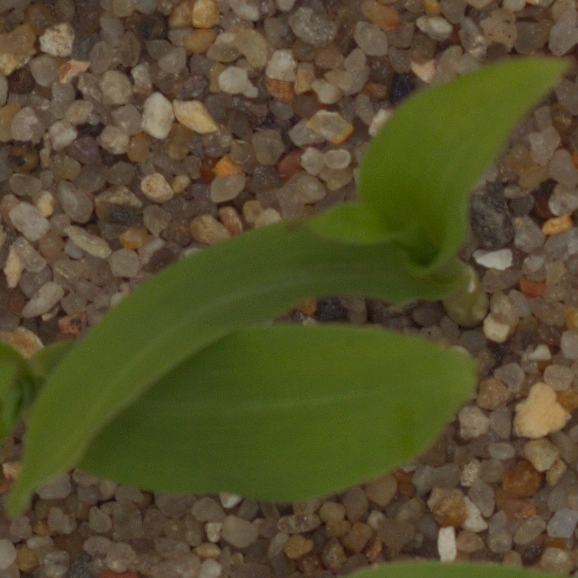

In [91]:
#Displaying the image
pred_img

In [93]:
#Resizing the image to 200*200, which is the input size of the CNN.
pred_img1= pred_img.resize((200,200))

In [106]:
#Converting the image into an array.
img_array = tf.keras.utils.img_to_array(pred_img1)
img_array = tf.expand_dims(img_array, 0)

In [108]:
#Predicting the image now
predictions = model3.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Maize with a 13.36 percent confidence.


In [110]:
#Image belongs to Maize as per the CNN model.

In [112]:
#Pickling the model for future use.
import pickle
with open('nnmodel.pkl','wb') as files:
    pickle.dump(model3,files)
files.close()

INFO:tensorflow:Assets written to: ram://d3f1769e-4bc6-489c-a614-bbae0f6562f8/assets


INFO:tensorflow:Assets written to: ram://d3f1769e-4bc6-489c-a614-bbae0f6562f8/assets
